In [1]:
from pathlib import Path
import cfgrib
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker

path_grib_file = Path(r"D:\Jetbrains\Python\Projects\ECMWF\output\20200101_to_20250101.grib")
ds = cfgrib.open_dataset(path_grib_file, decode_timedelta=False, indexpath=""
                        #  , backend_kwargs={'filter_by_keys': {"shortName": "tcc"}}
                         )
# ds = xr.open_dataset(path_grib_file, engine='cfgrib', decode_timedelta=False, indexpath="")
ds

<xarray.Dataset> Size: 129MB
Dimensions:     (time: 3656, step: 13, latitude: 13, longitude: 13)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 29kB 2020-01-01 ... 2025-01-01T12:00:00
  * step        (step) float64 104B 0.0 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
    surface     float64 8B ...
  * latitude    (latitude) float64 104B 56.5 56.38 56.25 ... 55.25 55.12 55.0
  * longitude   (longitude) float64 104B 11.77 11.89 12.02 ... 13.02 13.14 13.27
    valid_time  (time, step) datetime64[ns] 380kB ...
Data variables:
    tcc         (time, step, latitude, longitude) float32 32MB ...
    u200        (time, step, latitude, longitude) float32 32MB ...
    v200        (time, step, latitude, longitude) float32 32MB ...
    si200       (time, step, latitude, longitude) float32 32MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-02T10:41 GRIB to CDM+CF via cfgrib-0.9.1...

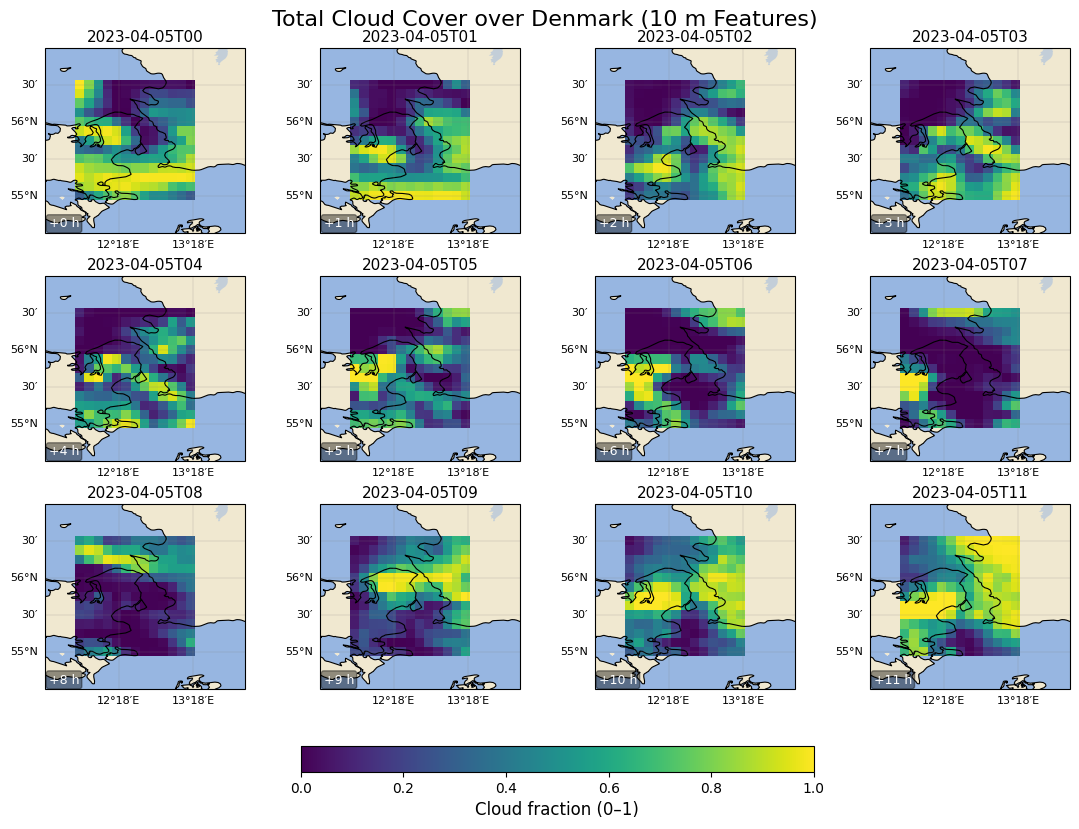

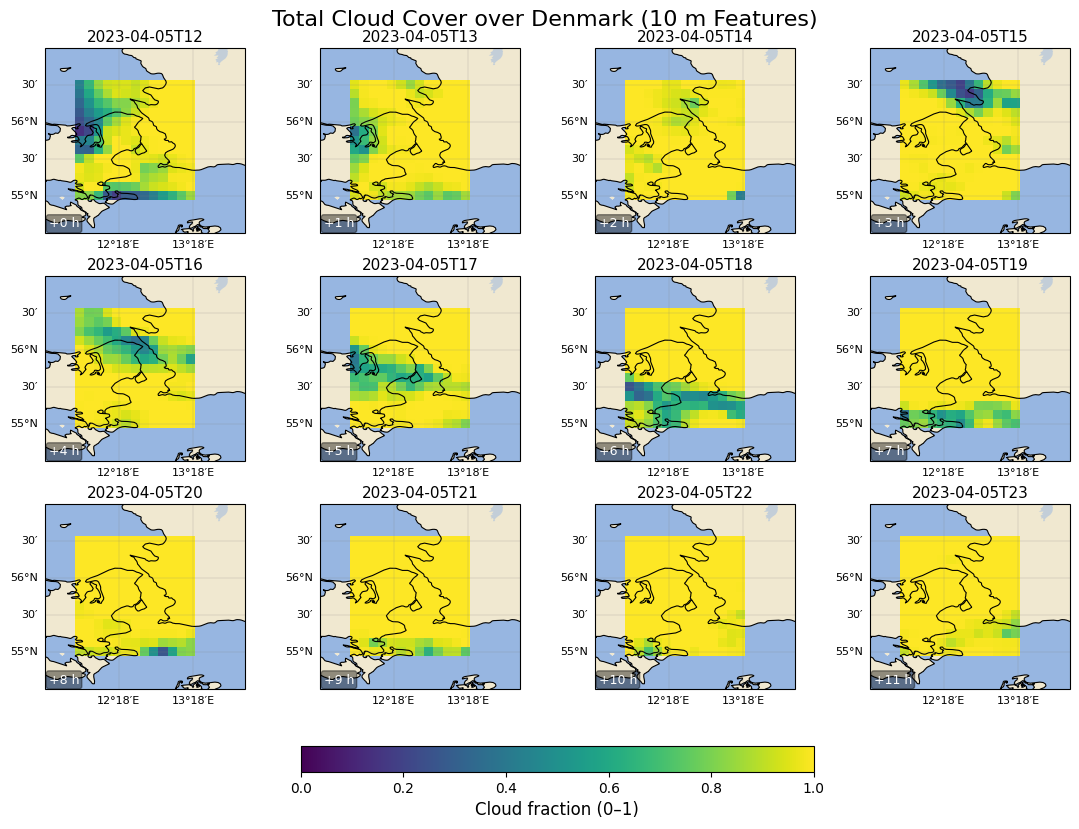

In [2]:
chosen_date = '2023-04-05'
timestamps = ds.sel(time=chosen_date).time.values
time_idx = 0
for ts in timestamps:
    # 1. Load dataset and slice off the initial time
    tcc = ds.sel(time=ts)['tcc']# .isel(time=0)    # now dims = (step, latitude, longitude)

    # 2. Forecast steps and shared color settings
    # steps = range(0, 13)
    cmap  = 'viridis'
    vmin, vmax = 0, 1

    # 3. Figure + Cartopy axes, with constrained layout
    fig, axes = plt.subplots(
        nrows=3, ncols=4,
        figsize=(11, 8),
        subplot_kw={'projection': ccrs.PlateCarree()},
        constrained_layout=True
    )
    axes = axes.flatten()

    for ax, step in zip(axes, range(0, 12, 1)):
        da = tcc.isel(step=step)

        # 4. Let Xarray handle the pcolormesh (avoids the flat shading edge‐mismatch)
        im = da.plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        )

        # 5. High-res coastlines, land/ocean, borders, lakes, rivers
        ax.add_feature(cfeature.OCEAN.with_scale('10m'))
        ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#f0e8d0')
        ax.coastlines('10m', linewidth=0.8)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'),
                    linestyle=':', linewidth=0.5)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), alpha=0.5)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), linewidth=0.5)

        # 6. Zoom in
        ax.set_extent([11.3, 14, 54.5, 57.0], crs=ccrs.PlateCarree())

        # 7. Tidy gridlines with fixed tick locations
        gl = ax.gridlines(
            draw_labels=True, dms=True,
            x_inline=False, y_inline=False,
            linewidth=0.3, color='gray', alpha=0.5
        )
        gl.top_labels   = False
        gl.right_labels = False
        gl.xlocator = mticker.FixedLocator(np.arange(11.3, 14, 1))
        gl.ylocator = mticker.FixedLocator(np.arange(54.5, 57.1, 0.5))
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}

        # 8. Per‐panel title and +h annotation
        vt_str = np.datetime_as_string(da['valid_time'].values, unit='h')
        ax.set_title(vt_str, fontsize=11, pad=4)
        ax.text(
            0.02, 0.03, f'+{step} h',
            transform=ax.transAxes,
            fontsize=9, color='white',
            bbox=dict(facecolor='black', alpha=0.4, boxstyle='round,pad=0.2')
        )

    # 9. Shared horizontal colorbar
    cbar = fig.colorbar(
        im, ax=axes.tolist(),
        orientation='horizontal',
        fraction=0.04, pad=0.06,
        ticks=np.linspace(vmin, vmax, 6)
    )
    cbar.set_label('Cloud fraction (0–1)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # 10. Super‐title
    fig.suptitle('Total Cloud Cover over Denmark (10 m Features)', fontsize=16, y=1.02)

    # 11. Save & show
    # plt.savefig('denmark_tcc_10m_nicer.png', dpi=300, bbox_inches='tight')
    plt.show()
    time_idx += 1


In [3]:
import pandas as pd
# build a grid of all latitude × longitude pairs and assign unique IDs
lats = ds.latitude.values
lons = ds.longitude.values

print(f'Rows in grid: {len(lats)}')
print(f'Columns in grid: {len(lons)}')

grid = pd.DataFrame(
    [(lat, lon) for lat in lats for lon in lons],
    columns=['lat', 'lon']
)
grid['grid_id'] = range(1, len(grid) + 1)
grid = grid[['grid_id', 'lat', 'lon']]

# write out to a CSV file
grid.to_csv('grid_cells.csv', index=False)

# inspect the first few rows
print(f'min latitude: {lats.min()}, max latitude: {lats.max()}')
print(f'min longitude: {lons.min()}, max longitude: {lons.max()}')
print(f'Number of grid cells: {len(grid)}')
grid.head()

Rows in grid: 13
Columns in grid: 13
min latitude: 55.0, max latitude: 56.5
min longitude: 11.77, max longitude: 13.27
Number of grid cells: 169


,grid_id,lat,lon
0,1,56.5,11.770
1,2,56.5,11.895
2,3,56.5,12.020
3,4,56.5,12.145
4,5,56.5,12.270


In [4]:
list(ds.data_vars.keys())

['tcc', 'u200', 'v200', 'si200']

In [5]:
# 1) turn the xarray into a DataFrame
df_all = ds.to_dataframe().reset_index()

# 2) merge in grid_ids by matching lat/lon
df_all = df_all.merge(
    grid,
    left_on=['latitude','longitude'],
    right_on=['lat','lon']
)

# 3) compute the actual timestamp = time + step hours
df_all['actual_time'] = df_all['time'] + pd.to_timedelta(df_all['step'], unit='h')

# 4) pivot so rows are actual_time, cols are grid‐cell values for each var
vars_ = list(ds.data_vars)  # e.g. ['tcc','u200','v200','si200']
df_ts = df_all.pivot_table(
    index='actual_time',
    columns='grid_id',
    values=vars_
)

# 5) flatten the MultiIndex columns
df_ts.columns = [f"{var}_cell{gid}" for var, gid in df_ts.columns]

df_ts.head()

,si200_cell1,si200_cell2,si200_cell3,si200_cell4,si200_cell5,si200_cell6,si200_cell7,si200_cell8,si200_cell9,si200_cell10,...,v200_cell160,v200_cell161,v200_cell162,v200_cell163,v200_cell164,v200_cell165,v200_cell166,v200_cell167,v200_cell168,v200_cell169
actual_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,13.442315,13.226312,13.007806,12.838250,12.613702,12.399835,12.130486,11.866876,11.563714,11.261285,...,-4.095036,-4.220463,-4.409916,-4.672794,-4.800907,-4.830631,-4.755680,-4.659489,-4.547672,-4.429996
2020-01-01 01:00:00,14.457870,14.394211,14.275864,14.140121,13.949326,13.769455,13.567856,13.384750,13.184067,12.937180,...,-4.423099,-4.542056,-4.740176,-5.049319,-5.291690,-5.466311,-5.523501,-5.484561,-5.390201,-5.256900
2020-01-01 02:00:00,13.930666,13.722231,13.567629,13.519472,13.505068,13.587893,13.775576,14.029482,14.187563,14.123415,...,-4.467246,-4.688437,-4.945273,-5.268149,-5.508628,-5.669150,-5.696372,-5.659507,-5.628257,-5.613730
2020-01-01 03:00:00,14.694736,14.222935,13.822605,13.619541,13.504124,13.498814,13.630222,13.900608,14.155064,14.284458,...,-4.375338,-4.532808,-4.785128,-5.204561,-5.572725,-5.879488,-6.063326,-6.204683,-6.329073,-6.458101
2020-01-01 04:00:00,15.965821,15.787477,15.425843,14.871766,14.263001,13.753846,13.474916,13.509400,13.602357,13.683167,...,-3.868532,-3.941164,-4.061037,-4.278933,-4.448732,-4.620852,-4.791140,-5.039797,-5.308352,-5.596804


In [6]:
# dump pickle
df_ts.to_pickle('forecast_2020_to_2025_hourly.pkl')

df = pd.read_pickle('forecast_2020_to_2025_hourly.pkl')
# 1) Build a new index at 1-minute frequency:
new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="1min")

# 2) Reindex to that minute‐level index:
df_minutely = df.reindex(new_index)
df_interp = df_minutely.interpolate(method="time")

df_interp.to_pickle('forecast_2020_to_2025_minutely_interpolated.pkl')